# Figure Generation for Manuscript

This notebook generates **Supplementary Figures S2, and S4** using **SAFE**.  
Figures are based on the *Saccharomyces cerevisiae* protein–protein interaction (PPI) network from **Michaelis et al. (2023)** and the genetic interaction (GI) network from **Costanzo et al. (2016)**.

---

## Supplementary Figure S2: SAFE Analysis of PPI Network
- SAFE clusters annotated with GO BP terms  
- Table of overrepresented biological processes (cluster ID, GO term, P-value, FDR)  

## Supplementary Figure S4: SAFE Analysis of GI Network
- SAFE clusters annotated with GO BP terms  
- Table of overrepresented biological processes (cluster ID, GO term, P-value, FDR)  

---

### Workflow
- **Input:** Yeast PPI network (Michaelis et al., 2023); yeast GI network (Costanzo et al., 2016)  
- **Tools:** Python, SAFE, NetworkX, Cytoscape, Matplotlib  
- **Output:** High-resolution figures for **Supplementary Figures S2 and S4**

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import json


from safepy import safe

%matplotlib inline

In [36]:
# Parameters

path_to_safe_data = "./"  # path to the cloned safe-data repository (https://github.com/baryshnikova-lab/safe-data.git)

In [37]:
# Common function definitions


def read_json(file_path):
    with open(file_path, "r") as file:
        return json.load(file)


def write_json(data, filename):
    with open(filename, "w") as file:
        json.dump(data, file, indent=4)

## Supplementary Figure S2.C & S2.D

SAFE analysis of the yeast protein–protein interaction (PPI) network (Michaelis et al., 2023).  
Clusters were identified with SAFE and annotated with overrepresented GO BP terms, with results summarized in a table (Cluster ID, GO term, P-value, FDR).

In [4]:
# Initialize the safe object

sf_ppi = safe.SAFE()

In [5]:
# Load Cytoscape session file

sf_ppi.load_network(
    network_file="./data/cytoscape/michaelis_2023.cys",
    node_key_attribute="label",  # i.e., node labels
)

Loading network from ./data/cytoscape/michaelis_2023_full_new.cys
Loading the cys file ./data/cytoscape/michaelis_2023_full_new.cys...
Loading the view: CytoscapeSession-2025_09_05-11_55/views/2297687-2471761-michaelis_2023.graphml.xgmml
Loading the first network: CytoscapeSession-2025_09_05-11_55/networks/2297646-michaelis_2023.graphml.xgmml
Calculating edge lengths...


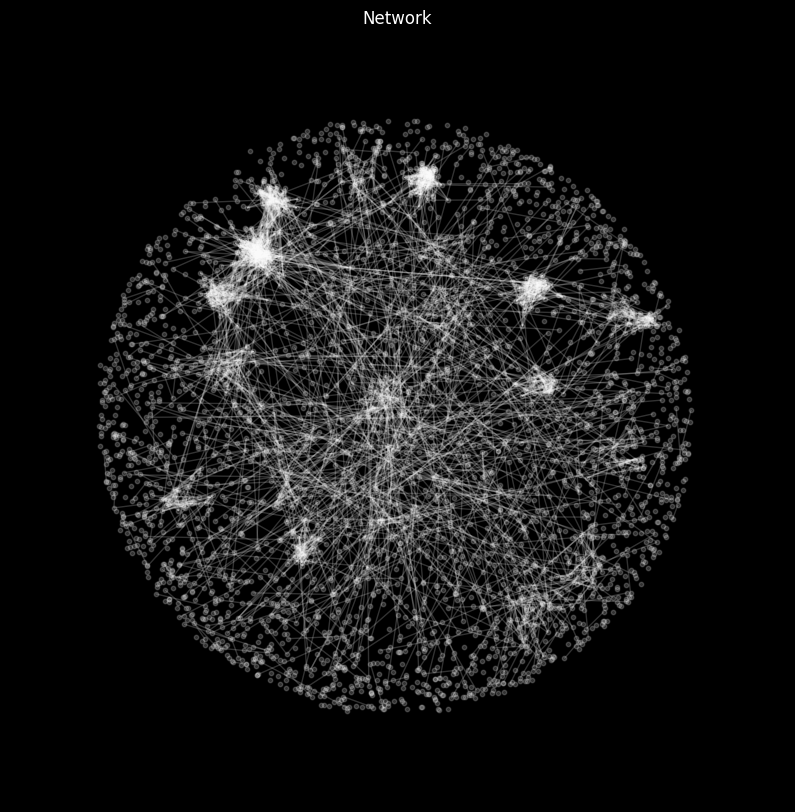

In [6]:
# View network as exported by Cytoscape

sf_ppi.plot_network()
plt.show()

## Build SAFE-compatible annotation file from JSON file

In [8]:
import os
import tarfile


def build_attributes_tar_file_from_dict(d, export_path, min_genes=5, max_genes=75):
    """
    Build an attributes tar.gz file from a dictionary mapping terms -> gene lists.
    """
    # Filter dictionary to only include terms with gene list sizes in [min_genes, max_genes]
    filtered_d = {
        term: genes_list
        for term, genes_list in d.items()
        if min_genes <= len(genes_list) <= max_genes
    }

    # Collect unique genes across filtered terms
    genes = sorted(set(gene for genes_list in filtered_d.values() for gene in genes_list))

    # Build header and rows
    header = ["ORF"] + list(filtered_d.keys())
    rows = []
    for gene in genes:
        row = [gene]
        for term, genes_list in filtered_d.items():
            row.append("1" if gene in genes_list else "0")
        rows.append(row)

    # Write output text file
    output_file = "output_file.txt"
    with open(output_file, "w") as file:
        file.write("\t".join(header) + "\n")
        for row in rows:
            file.write("\t".join(row) + "\n")

    # Tar and gzip the file
    with tarfile.open(export_path, "w:gz") as tar:
        tar.add(output_file)

    # Cleanup
    os.remove(output_file)

In [35]:
# Load the recent GO BP annotation from JSON and convert it into a text format that's compatible with SAFE

import json


with open("./data/json/annotations/go_biological_process.json", "r") as file:
    go_bp_json = json.load(file)

build_attributes_tar_file_from_dict(
    go_bp_json,
    "./data/tar.gz/annotations/go_biological_process.tar.gz",
    min_genes=5,
    max_genes=75,
)
print(f"Text successfully written and compressed")

Text successfully written and compressed


## Load attributes in the SAFE object

In [6]:
# Load the compressed attributes

sf_ppi.load_attributes(attribute_file="./data/tar.gz/annotations/go_biological_process.tar.gz")

Loading attributes from ./data/tar.gz/annotations/go_biological_process.tar.gz


In [25]:
# Explicitly define the node_distance metric and the neighborhood radius

sf_ppi.define_neighborhoods(
    node_distance_metric="shortpath_weighted_layout", neighborhood_radius=0.07
)

Node distance metric: shortpath_weighted_layout
Neighborhood definition: 0.07 x diameter
Number of nodes per neighborhood (mean +/- std): 17.48 +/- 30.01


In [26]:
# Go ahead and compute statistical significance of the neighborhoods

sf_ppi.enrichment_type = "permutation"
sf_ppi.enrichment_threshold = 0.01
sf_ppi.compute_pvalues(processes=8, num_permutations=1_000)

Current settings (possibly overwriting global ones):
	processes=8
	num_permutations=1000
Using randomization to calculate enrichment...


100%|██████████| 125/125 [02:37<00:00,  1.26s/it]









In [27]:
# Define top attributes

sf_ppi.define_top_attributes()

Criteria for top attributes:
- minimum number of enriched neighborhoods: 10
- region-specific distribution of enriched neighborhoods as defined by: connectivity
Number of top attributes: 45


In [28]:
# Determine clustering threshold and trim domains

sf_ppi.define_domains(attribute_distance_threshold=0.001)
sf_ppi.trim_domains()

Number of domains: 38 (containing 1-4 attributes)
Removed 16 domains because they were the top choice for less than 10 neighborhoods.


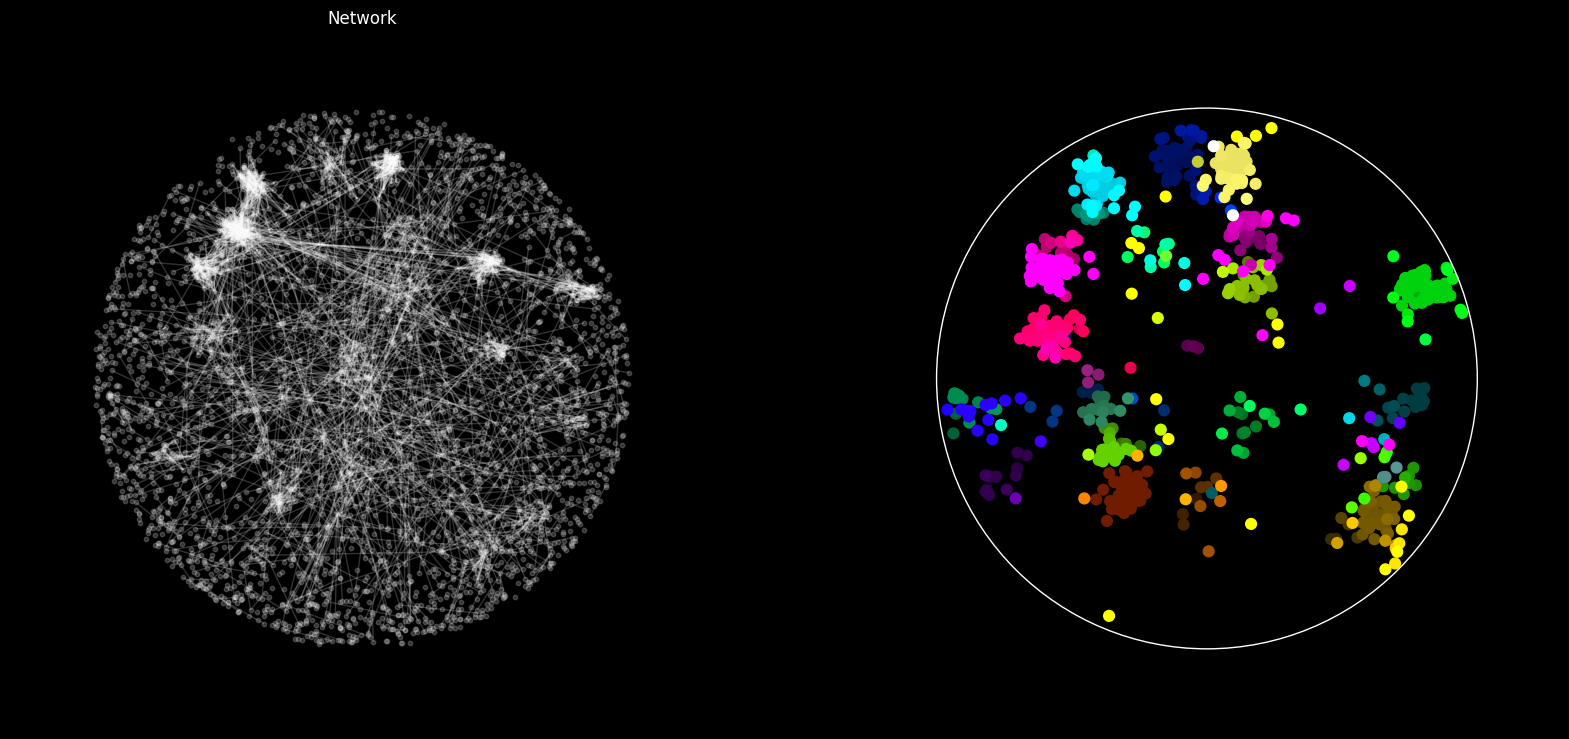

In [34]:
# Plot network

sf_ppi.plot_composite_network(show_each_domain=False, show_domain_ids=False, labels=[])

# Save the figure
# plt.savefig('./png/supp_fig_2c.png', facecolor="black", dpi=350)

## Export domain information for head-to-head comparison

Domain-level results are exported from RISK for direct comparison with SAFE in  
`risk_network/fig_1_supp_fig_2_4_5_6.ipynb`.

In [2]:
import networkx as nx

# Total number of nodes
N = len(sf_ppi.graph.nodes)

# Build reversed mapping: 0..N-1 mapped to labels of nodes from back to front
node_order = list(sf_ppi.graph.nodes)  # graph iteration order
labels = nx.get_node_attributes(sf_ppi.graph, "label")

# Reverse map (optional: still available if you need 0..N-1 -> label)
reversed_map = {i: labels[node_order[j]] for i, j in enumerate(range(N - 1, -1, -1))}

# Create DataFrame
ppi_domain_df = sf_ppi.node2domain.copy()

# Adjusting the logic to store the node label instead of the row index
ppi_domain_dict = {}

for index, row in ppi_domain_df.iterrows():
    primary_domain = int(row["primary_domain"])

    if primary_domain not in ppi_domain_dict:
        ppi_domain_dict[primary_domain] = []

    # Get node label for this row index
    label = labels.get(index, str(index))  # fallback to index if label missing
    ppi_domain_dict[primary_domain].append(label)

# Export as JSON for further analysis
write_json(ppi_domain_dict, "./data/json/domains/20250904_safe_domains_michaelis_2023.json")

## Supplementary Figure S3.C

SAFE analysis of the yeast genetic interaction (GI) network (Costanzo et al., 2016).  
Clusters were identified with SAFE and annotated with overrepresented GO BP terms, with results summarized in a table (Cluster ID, GO term, P-value, FDR).

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

from safepy import safe

%matplotlib inline

## First, we have to map ORFs to standard gene names in the Costanzo network

In [18]:
## Initialize the safe object

sf_gi = safe.SAFE()

In [2]:
# Let's map standard gene names to the ORF node labels...

# Now manipulate the Costanzo network for it to be workable with standard gene names
import json
import pickle


def read_gpickle(filepath):
    with open(filepath, "rb") as f:
        G = pickle.load(f)
    return G


def write_gpickle(graph, filepath):
    with open(filepath, "wb") as file:
        pickle.dump(graph, file)


# Load ORF to standard gene name mapping dict
def read_json(file_path):
    with open(file_path, "r") as file:
        return json.load(file)


# Load the mapping dictionary
sys_gene_to_std_gene_map = read_json("./data/json/sgd/sys_gene_to_std_gene_map.json")
costanzo_network_path = "./data/gpickle/Costanzo_Science_2016.gpickle"
costanzo_gpickle = read_gpickle(costanzo_network_path)

# Update the 'label' attribute for each node based on 'label_orf'
for node_id, data in costanzo_gpickle.nodes(data=True):
    if "label_orf" in data:
        # Update 'label' using the mapping, if it exists; otherwise, keep the current 'label_orf'
        data["label_orf"] = sys_gene_to_std_gene_map.get(data["label_orf"], data["label_orf"])

write_gpickle(costanzo_gpickle, "./data/gpickle/costanzo_2016_std_names.gpickle")

# Display nodes to confirm attributes are removed
# list(costanzo_network_relabeled.nodes(data=True))

## Now, we can begin to annotate the network

Loading network from ./data/gpickle/costanzo_2016_std_names.gpickle


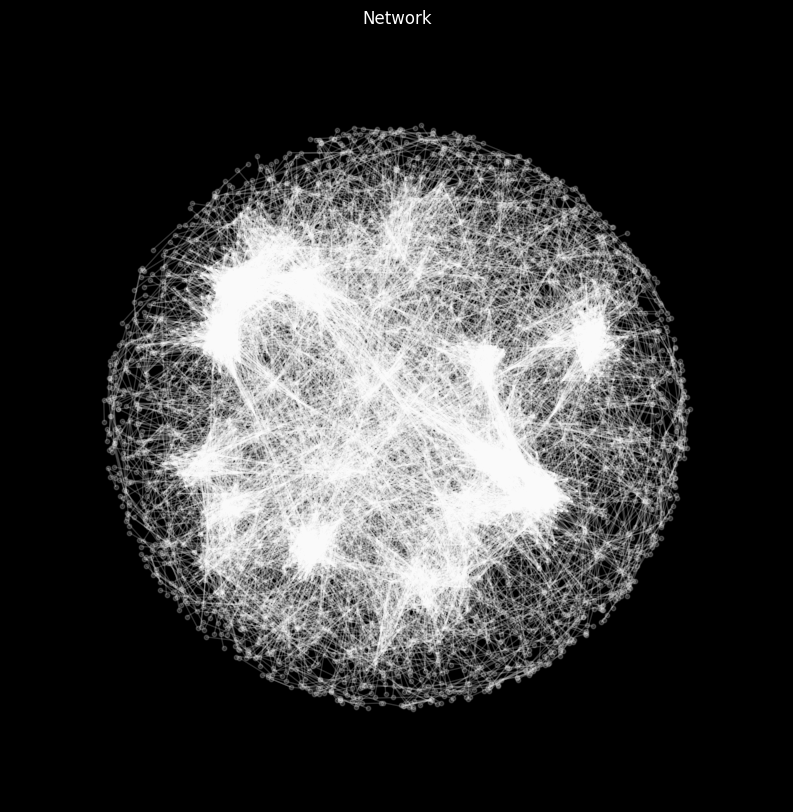

In [107]:
## Initialize the safe object again

sf_gi = safe.SAFE()

# Load Cytoscape session file
sf_gi.load_network(
    network_file="./data/gpickle/costanzo_2016_std_names.gpickle",  # Metabolic FM network
)

# View network as exported by Cytoscape
sf_gi.plot_network()
plt.show()

In [108]:
# Now load the attributes...

sf_gi.load_attributes(attribute_file="./data/tar.gz/annotations/go_biological_process.tar.gz")

# Explicitly define the node_distance metric and the neighborhood radius
sf_gi.define_neighborhoods(
    node_distance_metric="shortpath_weighted_layout", neighborhood_radius=0.06
)

Loading attributes from ./data/tar.gz/annotations/go_biological_process.tar.gz
Node distance metric: shortpath_weighted_layout
Neighborhood definition: 0.06 x diameter
Number of nodes per neighborhood (mean +/- std): 16.09 +/- 27.30


In [109]:
# Go ahead and compute statistical significance of the neighborhoods

sf_gi.enrichment_type = "permutation"
sf_gi.compute_pvalues(processes=1, num_permutations=1_000)

Current settings (possibly overwriting global ones):
	processes=1
	num_permutations=1000
Using randomization to calculate enrichment...


100%|████████████████████████████████████████████████████████████████| 1000/1000 [10:52<00:00,  1.53it/s]


In [111]:
# Define top attributes

sf_gi.define_top_attributes()

Criteria for top attributes:
- minimum number of enriched neighborhoods: 10
- region-specific distribution of enriched neighborhoods as defined by: connectivity
Number of top attributes: 172


In [112]:
# Try to match RISK's group count

sf_gi.define_domains(attribute_distance_threshold=0.54)
sf_gi.trim_domains()

Number of domains: 62 (containing 1-25 attributes)
Removed 38 domains because they were the top choice for less than 10 neighborhoods.


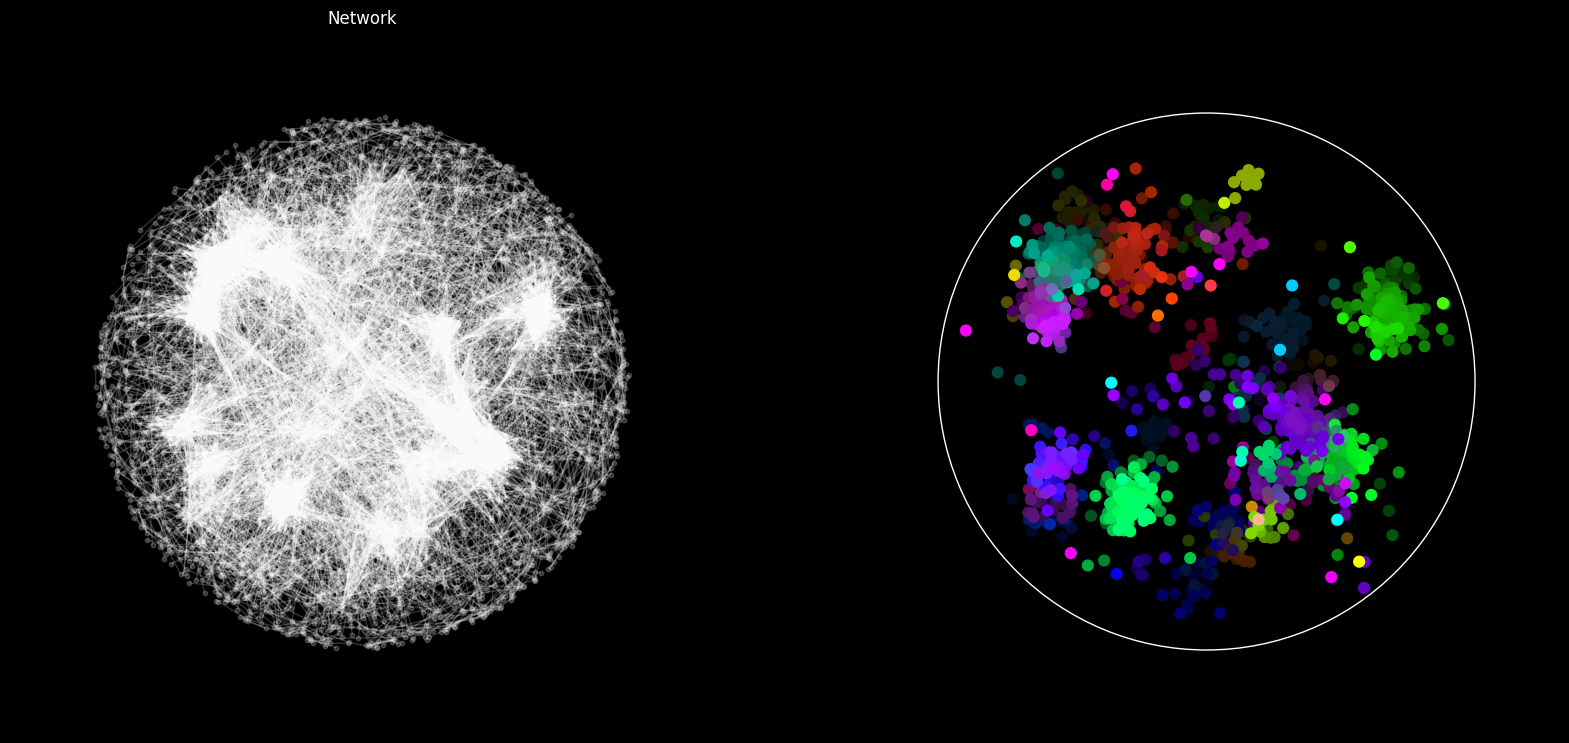

In [128]:
# Plot simplified composite network

sf_gi.plot_composite_network(show_each_domain=False, show_domain_ids=False, labels=[])

# Save the figure

# plt.savefig('./png/publication/safe_costanzo_2016.png', facecolor="black", dpi=350)

## Export domain information for head-to-head comparison

Domain-level results are exported from SAFE for direct comparison with RISK in  
`risk_network/supp_fig_1_3.ipynb`.

In [133]:
# Create DataFrame

gi_domain_df = sf_gi.node2domain.copy()

# Adjusting the logic to store the row index instead of the node value
gi_domain_dict = {}

for index, row in gi_domain_df.iterrows():
    primary_domain = int(row["primary_domain"])

    if primary_domain not in gi_domain_dict:
        gi_domain_dict[primary_domain] = []

    # Store the row index instead of node value
    gi_domain_dict[primary_domain].append(index)

## Export as JSON for further analysis
# write_json(gi_domain_dict, './data/json/domains/20250130_safe_domains_costanzo_2016.json')

In [2]:
# Create a mapping of SAFE's node IDs to labels

# write_json(dict(zip(sf_gi.nodes['id'], sf_gi.nodes['key'])), './data/json/domains/20250130_safe_node_id_to_label_costanzo_2016.json')